Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
# importing numpy and scipy stats
from scipy.stats import mode
import numpy as np


In [91]:
target = 'status_group'
y_train = train[target]

y_train.shape

(59400,)

In [92]:
x_train['longitude'].isnull().sum()

0

In [93]:
x_train['ward'].isnull().sum()

0

In [0]:
# Creating the list of the columns that I want to drop here and
# then will pass them into the wrangle function
target = 'status_group'
# This is a list of some of the colums that I want to drop
# Will drop subvillage -- because similar results as lat and lon
# Dropping funder:  has high cardinality
# Dropping the wpt_name:  has high cardinality is the name of the water point
# Dropping payment_type:  same as payment(duplicate)
cols_to_drop = ['id', 'quantity_group', 'recorded_by', "subvillage", 
                'num_private', 'funder', 'wpt_name' ,'scheme_name', 'payment_type',
                'quality_group', ]

In [0]:
# These are some inner functions in my wrangle function that help
# With the fixing the latitude and the longitude
def myLatitude(theRow,df):
  
  if pd.isnull(theRow['latitude']):
    theWard = theRow['ward']
    lat = df[df['ward'] == theWard]
    theMode = mode(lat['latitude'])
    return (theMode[0][0])
  return (theRow['latitude'])

def myLon(theRow, df): 
  if (pd.isnull(theRow['longitude'])):
    lon = df[df['ward'] == theRow['ward']]
    theMode = mode(lon['longitude'])
    return (theMode[0][0])
  return (theRow['longitude'])

In [0]:
# This is my wrangle function

def wrangleFxn(df, cols_to_drop ,numCardinal=50, useMode=True, num=None, highVar=None, lowVar=None, useDropList=True ):
  ''' This is the wrangle function
      It will take in a dataFrame either the train, test, or validate.
      It should have the TARGET already removed from it. 

      cols_to_drop:   List of features that you want to drop automatically from 
                      the dataFrame
                      It will drop the columns before looking at the cardinality of the
                      columns.

      numCardinal:  default is 50. This is the threshold.  If it is less
                    than  or equal to this number it is retained in the 
                    features.
      useMode:  default is True.  This will use the apply functiontion to 
                make the lat and lon have values similar to those in 
                the ward that it is found.
      num:      default is None.  It this is set to a number, 
                it will further reduce the cardinality of the
                cardinal features to a specified number. 
      
      highVar:  Default is None. If set will drop any columns that have more 
                variance than what is set here as the threshold.  Should be
                set as a float ie(.90 or .8)
      
      lowVar:   Default is None. if set will drop any columns who have less
                variance than here.  Should be set as a float ie(.1 or .234)

      useDropList:  Default is True.  When is True will use the cols_to_drop parameter.
                    When false will not use the cols_to_drop parameter 

      returns:  Will return the datframe prepared for the pipeline.

  '''
  
  
  target = 'status_group'
  # making the copy
  df = df.copy()
  # will try to drop the target if it is present
  if target in df.columns:
    df = df.drop(columns=[target])
  
  # Will be setting the long and lat before doing any dropping
  df['latitude'] = df['latitude'].replace(-2e-08, 0)

  # Getting rid of the zeros in the latitude and the longitude putting in 
  # np.nan
  cols_w_zeros = ['latitude', 'longitude']

  for col in cols_w_zeros:
    df[col] = df[col].replace(0, np.nan)

  if useMode == True:
    #This is to make the latitude and the longitude have
    # numbers similar to those whose region they are in
    df['latitude'] = df.apply(myLatitude, axis=1, args=(df,))
    df['longitude'] = df.apply(myLon, axis=1, args=(df,))
    pd.to_numeric(df['latitude'])
  
  # Changing the format to dateTime format and then
  # making 
  df['date_recorded'] = pd.to_datetime(df['date_recorded'])
  df['construction_year'] = pd.to_datetime(df['construction_year'])
  df['construction_year'] = df['construction_year'].dt.year

  df['year_recorded'] = df['date_recorded'].dt.year
  df['month_recorded'] = df['date_recorded'].dt.month
  df['day_recorded'] = df['date_recorded'].dt.day

  # Making a new feature that will be "year_age"
  df['year_age']  = df['year_recorded'] - df['construction_year']
  
  # Dropping the columns preset to drop
  if useDropList == True:
    df = df.drop(columns= cols_to_drop)

  # Getting a list of the cardinal features at the start
  cardinals = df.select_dtypes(exclude='number')

  # This to drop features that are left that have high skew (almost no variance)
  # or possibly too much variance
  if highVar != None:
    # Getting a list of the cardinal features at the start
    cardinals = df.select_dtypes(exclude='number')
    tCol = cardinals.columns.to_list()
    for col in tCol:
      if df[col].value_counts(normalize=True, dropna=False).to_list()[0]  > highVar:
        df = df.drop(columns=[col])
  
  if lowVar != None:
    # Getting a list of the cardinal features at the start
    cardinals = df.select_dtypes(exclude='number')
    tCol = cardinals.columns.to_list()
    
    for col in tCol:
      if df[col].value_counts(normalize=True, dropna=False).to_list()[0] < lowVar:
        df = df.drop(columns=[col])


  # Getting the number of features that are numerical
  numerical_features = df.select_dtypes(include='number').columns.tolist()

  # Getting the amounts in each feature of the cardinal features
  cardinalFeatureAmounts = df.select_dtypes(exclude='number')
  cardinalFeatureAmounts = cardinalFeatureAmounts.nunique()
  # checking to see if 'ward' is in the list

  # Creating a list of the features that have less than 50 cardinality
  cardinal = cardinalFeatureAmounts[cardinalFeatureAmounts <= numCardinal].index.tolist()
  
  if num != None:
    #This is to reduce the number of features in the cardinal groups
    for feature in cardinal:
      # getting the top specified amount
      topNum = df[feature].value_counts().index[:num-1].tolist()
      # replace those that are not in there with 'other'
      df.loc[~df[feature].isin(topNum), feature] = 'Other'

  # List of all the features
  features = numerical_features + cardinal

  
  

  return df[features]

In [0]:
x_train1 = wrangleFxn(train, cols_to_drop=cols_to_drop, numCardinal=55, useMode=True, num=None, highVar=.90, lowVar=.3)

In [98]:
x_train1.isnull().sum()

amount_tsh                  0
gps_height                  0
longitude                1458
latitude                 1458
region_code                 0
district_code               0
population                  0
construction_year           0
year_recorded               0
month_recorded              0
day_recorded                0
year_age                    0
public_meeting           3334
scheme_management        3877
permit                   3056
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
water_quality               0
quantity                    0
source_class                0
waterpoint_type             0
waterpoint_type_group       0
dtype: int64

In [0]:
x_test = wrangleFxn(test, cols_to_drop=cols_to_drop, numCardinal=55, useMode=True, num=20, highVar=.88, lowVar=.5)

In [0]:
# going to do some sklearn imports
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
import category_encoders as ce 
from sklearn.impute import SimpleImputer

In [139]:
# making the pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(), SimpleImputer(strategy='mean',),
    
    RandomForestClassifier(n_estimators=150, max_depth=14, min_samples_split=3, min_samples_leaf=2, random_state=42 )
)

pipeline.fit(x_train1, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['public_meeting', 'scheme_management',
                                     'permit', 'extraction_type',
                                     'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'water_quality', 'quantity',
                                     'source_class', 'waterpoint_type',
                                     'waterpoint_type_group'],
                               drop_invariant=False, handle_missing='value',
                               ha...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=14, max_features='auto',
                                        max_leaf_nodes=Non

In [140]:
pipeline.score(x_train1, y_train)

0.7964141414141415

In [0]:
y_pred = pipeline.predict(x_train1)

In [0]:
# Plotting the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels



In [0]:
def plotting_confusion_matrix(y_true, y_pred):
  theLabels = unique_labels(y_train)
  cols = [f"Predicted {label}" for label in theLabels]
  ind = [f"True {label}" for label in theLabels]
  # create a pandas dataFrame
  return plot_confusion_matrix(pipeline, x_train1, y_train, xticks_rotation='vertical', values_format='d');
  
  #return #sns.heatmap(theData, annot=True, fmd='d', cmap='viridis')

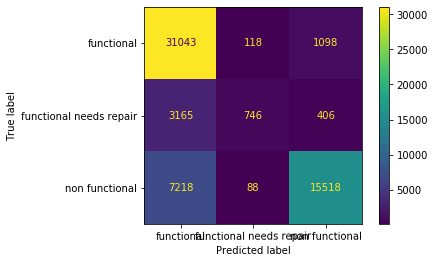

In [164]:
plotting_confusion_matrix(y_train, y_pred)

In [0]:
from sklearn.metrics import classification_report

In [168]:
print(classification_report(y_train, y_pred))

                         precision    recall  f1-score   support

             functional       0.75      0.96      0.84     32259
functional needs repair       0.78      0.17      0.28      4317
         non functional       0.91      0.68      0.78     22824

               accuracy                           0.80     59400
              macro avg       0.81      0.61      0.63     59400
           weighted avg       0.81      0.80      0.78     59400

